# **MOVIE_DATA_ANALYSIS🎥🎬🎞️🍿**

## **과제 3️⃣**
### 배우/감독 네트워크 분석 및 성공 패턴 발견

#### 주요 배우와 감독들의 협업 관계를 네트워크로 시각화하고, 성공적인 콜라보레이션 패턴을 발견하여 캐스팅 전략에 대한 인사이트를 도출하세요.

#### **TOP 40 감독-배우 콤보 네트워크 분석**

전체 데이터 수: 927개
필터링 후 데이터 수: 927개

📊 네트워크 분석 설정:
상위 배우 수: 10명
최소 협업 횟수: 2회
정렬 기준: avg_revenue
상위 엣지 수: 50개

🤝 협업 데이터 생성:
총 협업 관계: 8,838개
유효한 협업 관계: 341개

📈 상위 50개 협업 관계:


,감독,배우,협업횟수,평균수익
1,김용화,김향기,2,1091.0억원
2,김용화,도경수,2,1091.0억원
3,김용화,이준혁,2,1091.0억원
4,김용화,주지훈,2,1091.0억원
5,최동훈,오달수,2,959.5억원
6,최동훈,이정재,2,959.5억원
7,최동훈,전지현,2,959.5억원
8,김한민,류승룡,2,957.1억원
9,김용화,김동욱,4,759.8억원
10,이병헌,양현민,2,746.3억원



🕸️ 네트워크 그래프:
노드 수: 63개
엣지 수: 50개

🎨 네트워크 시각화 완료!


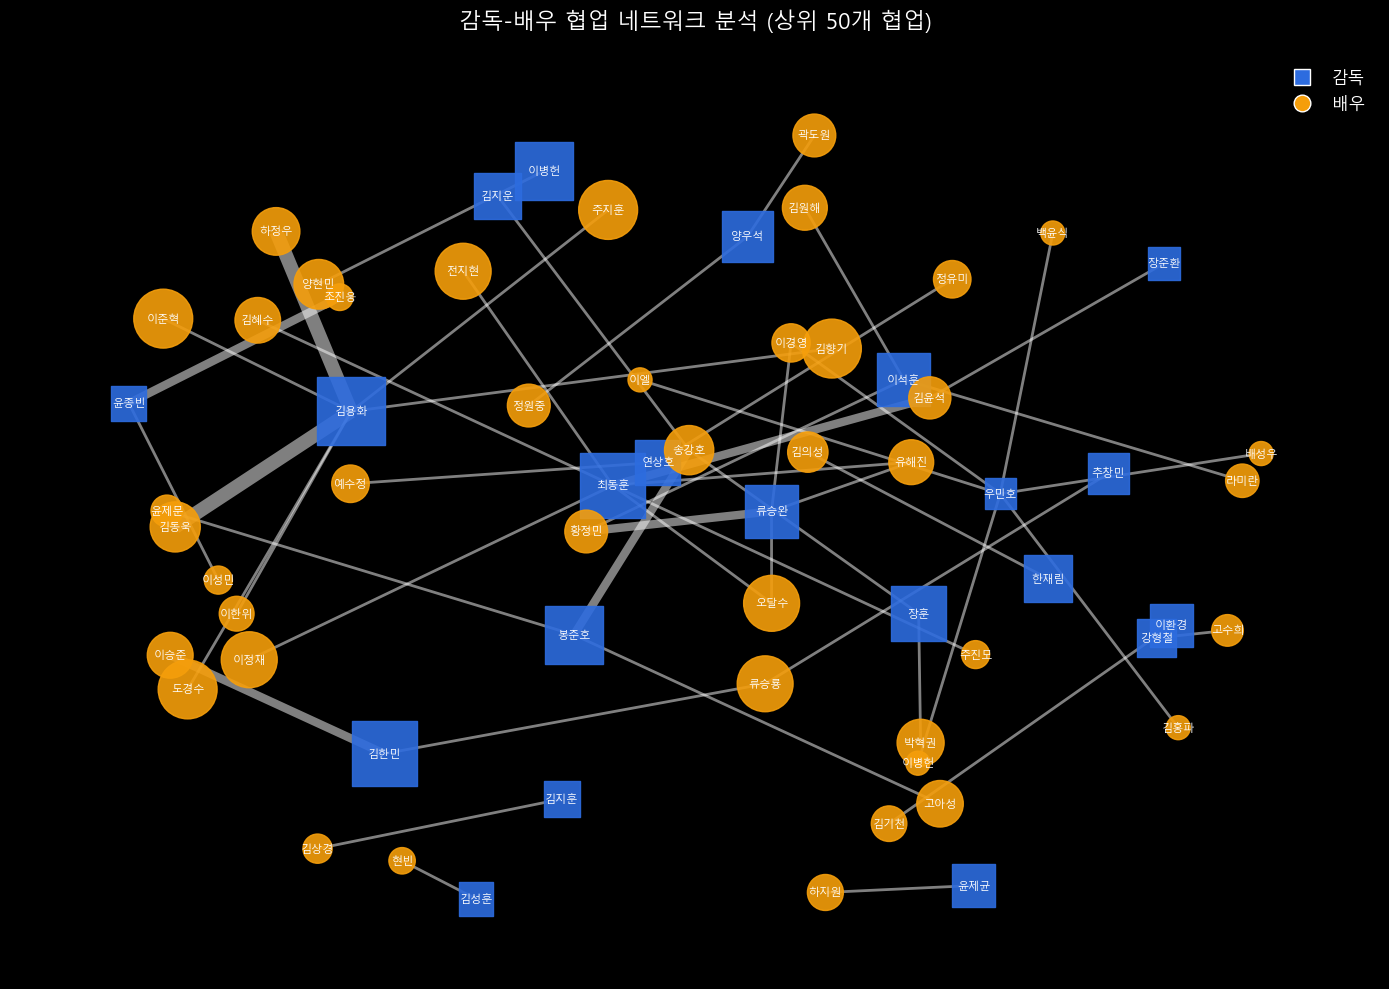

In [11]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from itertools import islice
from IPython.display import display
import warnings

# 경고 메시지 무시 설정
warnings.filterwarnings('ignore', category=UserWarning)

# 한글 폰트 설정
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

# 파일 경로
file_path = './data/processed/kobis_weekly_final.csv'

# 데이터 로드
df = pd.read_csv(file_path)

print(f"전체 데이터 수: {len(df):,}개")

# 숫자형 컬럼 변환
numeric_columns = ['release_year', 'budget', 'revenue', 'vote_average', 'runtime']
for col in numeric_columns:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')

# 기간 필터링 (2005-2025)
if 'release_year' in df.columns:
    df = df[df['release_year'].between(2005, 2025)]

print(f"필터링 후 데이터 수: {len(df):,}개")

# ROI 및 순이익 계산
df['roi'] = np.where((df['budget'] > 0) & (df['revenue'] > 0),
                     df['revenue'] / df['budget'], np.nan)
df['net_profit'] = df['revenue'] - df['budget']

# 파이프 구분자 파싱 함수
def split_pipe(s):
    return [x.strip() for x in str(s).split('|') if x.strip()]

# 분석 파라미터 설정
TOP_N_CAST = 10  # 상위 배우 N명
MIN_COLLABS = 2  # 최소 협업 횟수
METRIC_EDGE_ORDER = 'avg_revenue'  # 정렬 기준
TOP_K_EDGES = 50  # 상위 K개 엣지

print(f"\n📊 네트워크 분석 설정:")
print(f"상위 배우 수: {TOP_N_CAST}명")
print(f"최소 협업 횟수: {MIN_COLLABS}회")
print(f"정렬 기준: {METRIC_EDGE_ORDER}")
print(f"상위 엣지 수: {TOP_K_EDGES}개")

# 감독-배우 협업 데이터 생성
collaboration_data = []

for _, row in df.iterrows():
    director = str(row.get('director_name_ko', '')).strip()
    if not director:
        continue
    
    cast_list = split_pipe(row.get('cast_names_ko', ''))
    
    for actor in cast_list[:TOP_N_CAST]:
        collaboration_data.append({
            'director_label': director,
            'actor_label': actor,
            'movie_id': row.get('movie_id'),
            'release_year': row.get('release_year'),
            'revenue': row.get('revenue'),
            'budget': row.get('budget'),
            'roi': row.get('roi'),
            'net_profit': row.get('net_profit')
        })

print(f"\n🤝 협업 데이터 생성:")
print(f"총 협업 관계: {len(collaboration_data):,}개")

# 협업 통계 집계
collaboration_df = pd.DataFrame(collaboration_data)
edges_df = (collaboration_df
            .groupby(['director_label', 'actor_label'], as_index=False)
            .agg(
                n_collabs=('movie_id', 'nunique'),
                avg_revenue=('revenue', 'mean'),
                avg_roi=('roi', 'mean'),
                avg_net_profit=('net_profit', 'mean'),
                first_year=('release_year', 'min'),
                last_year=('release_year', 'max')
            )
            .query('n_collabs >= @MIN_COLLABS')
            .sort_values([METRIC_EDGE_ORDER, 'n_collabs'], ascending=[False, False])
           )

print(f"유효한 협업 관계: {len(edges_df)}개")

# 상위 협업 관계 선택
top_edges = edges_df.head(TOP_K_EDGES).copy()

print(f"\n📈 상위 {TOP_K_EDGES}개 협업 관계:")
display_edges = top_edges[['director_label', 'actor_label', 'n_collabs', 'avg_revenue']].copy()
display_edges['avg_revenue'] = display_edges['avg_revenue'].apply(lambda x: f"{x/1e8:.1f}억원")
display_edges.columns = ['감독', '배우', '협업횟수', '평균수익']
display_edges.index = range(1, len(display_edges) + 1)
display(display_edges.head(10))

# 네트워크 그래프 생성
G = nx.Graph()

for _, row in top_edges.iterrows():
    director_node = ('director', row['director_label'])
    actor_node = ('actor', row['actor_label'])
    
    G.add_node(director_node, role='director', label=row['director_label'])
    G.add_node(actor_node, role='actor', label=row['actor_label'])
    
    G.add_edge(director_node, actor_node,
               weight=int(row['n_collabs']),
               avg_revenue=float(row['avg_revenue']) if pd.notna(row['avg_revenue']) else 0.0,
               avg_net_profit=float(row['avg_net_profit']) if pd.notna(row['avg_net_profit']) else 0.0,
               avg_roi=float(row['avg_roi']) if pd.notna(row['avg_roi']) else 0.0)

print(f"\n🕸️ 네트워크 그래프:")
print(f"노드 수: {G.number_of_nodes()}개")
print(f"엣지 수: {G.number_of_edges()}개")

# 레이아웃 설정
pos = nx.spring_layout(G, seed=42, k=0.8)

# 노드 분류
directors = [n for n, d in G.nodes(data=True) if d['role'] == 'director']
actors = [n for n, d in G.nodes(data=True) if d['role'] == 'actor']

# 엣지 두께 계산
weights = [G.edges[e]['weight'] for e in G.edges()]
w_min, w_max = min(weights), max(weights)
edge_widths = [2 + 8*((w-w_min)/(w_max-w_min)) for w in weights] if w_max != w_min else [6]*len(weights)

# 노드 크기 계산 (평균 수익 기준)
METRIC_NODE_SIZE = 'avg_revenue'

for _, row in top_edges.iterrows():
    for node_key, label in [(('director', row['director_label']), row['director_label']),
                           (('actor', row['actor_label']), row['actor_label'])]:
        prev_value = G.nodes[node_key].get(METRIC_NODE_SIZE, 0.0)
        current_value = float(row[METRIC_NODE_SIZE]) if pd.notna(row[METRIC_NODE_SIZE]) else 0.0
        if current_value > prev_value:
            G.nodes[node_key][METRIC_NODE_SIZE] = current_value

# 노드 크기 정규화
metric_values = {n: G.nodes[n].get(METRIC_NODE_SIZE, 0.0) for n in G.nodes()}
values_array = np.array(list(metric_values.values()), dtype=float)
values_log = np.log1p(np.abs(values_array))
vmin, vmax = float(values_log.min()), float(values_log.max())

normalized_values = {}
for node in G.nodes():
    if vmax > vmin:
        normalized_values[node] = (np.log1p(abs(metric_values[node])) - vmin) / (vmax - vmin)
    else:
        normalized_values[node] = 0.5

# 노드 크기 설정
MIN_SIZE_ACTOR, MAX_SIZE_ACTOR = 300, 1800
MIN_SIZE_DIRECTOR, MAX_SIZE_DIRECTOR = 500, 2400

node_sizes = {}
for node, norm_val in normalized_values.items():
    if G.nodes[node]['role'] == 'director':
        node_sizes[node] = MIN_SIZE_DIRECTOR + norm_val * (MAX_SIZE_DIRECTOR - MIN_SIZE_DIRECTOR)
    else:
        node_sizes[node] = MIN_SIZE_ACTOR + norm_val * (MAX_SIZE_ACTOR - MIN_SIZE_ACTOR)

# 네트워크 시각화
plt.figure(figsize=(14, 10))
plt.style.use('dark_background')

# 엣지 그리기
nx.draw_networkx_edges(G, pos, width=edge_widths, alpha=0.5, edge_color='white')

# 감독 노드 (파란 사각형)
nx.draw_networkx_nodes(
    G, pos, nodelist=directors,
    node_size=[node_sizes[n] for n in directors],
    node_color='#2D6CDF', node_shape='s', alpha=0.9
)

# 배우 노드 (주황 원형)
nx.draw_networkx_nodes(
    G, pos, nodelist=actors,
    node_size=[node_sizes[n] for n in actors],
    node_color='#F59E0B', node_shape='o', alpha=0.9
)

# 라벨
labels = {n: d.get('label', '') for n, d in G.nodes(data=True)}
nx.draw_networkx_labels(G, pos, labels=labels, font_size=8, 
                       font_family='Malgun Gothic', font_color='white')

# 제목 설정
plt.title(f'감독-배우 협업 네트워크 분석 (상위 {TOP_K_EDGES}개 협업)', 
          fontsize=16, color='white', pad=20)

# 범례
from matplotlib.lines import Line2D
legend_elements = [
    Line2D([0], [0], marker='s', color='w', label='감독',
           markerfacecolor='#2D6CDF', markersize=12, linestyle='None'),
    Line2D([0], [0], marker='o', color='w', label='배우',
           markerfacecolor='#F59E0B', markersize=12, linestyle='None')
]
plt.legend(handles=legend_elements, loc='upper right', frameon=False, fontsize=12)

plt.axis('off')
plt.tight_layout()

print(f"\n🎨 네트워크 시각화 완료!")
plt.show()

전체 데이터 수: 927개
필터링 후 데이터 수: 927개

📊 네트워크 분석 설정:
상위 배우 수: 5명
최소 협업 횟수: 2회
정렬 기준: avg_revenue
상위 엣지 수: 40개

🤝 협업 데이터 생성:
총 협업 관계: 4,552개
유효한 협업 관계: 178개

상위 40개 협업 관계:


,감독,배우,협업횟수,평균수익
1,김용화,김향기,2,1091.0억원
2,김용화,주지훈,2,1091.0억원
3,최동훈,이정재,2,959.5억원
4,최동훈,전지현,2,959.5억원
5,김한민,류승룡,2,957.1억원
6,봉준호,송강호,3,736.0억원
7,김용화,김동욱,4,693.2억원
8,김용화,하정우,4,693.2억원
9,최동훈,김윤석,2,687.1억원
10,장훈,박혁권,2,679.3억원



네트워크 그래프:
노드 수: 56개
엣지 수: 40개

🎨 네트워크 시각화 완료!


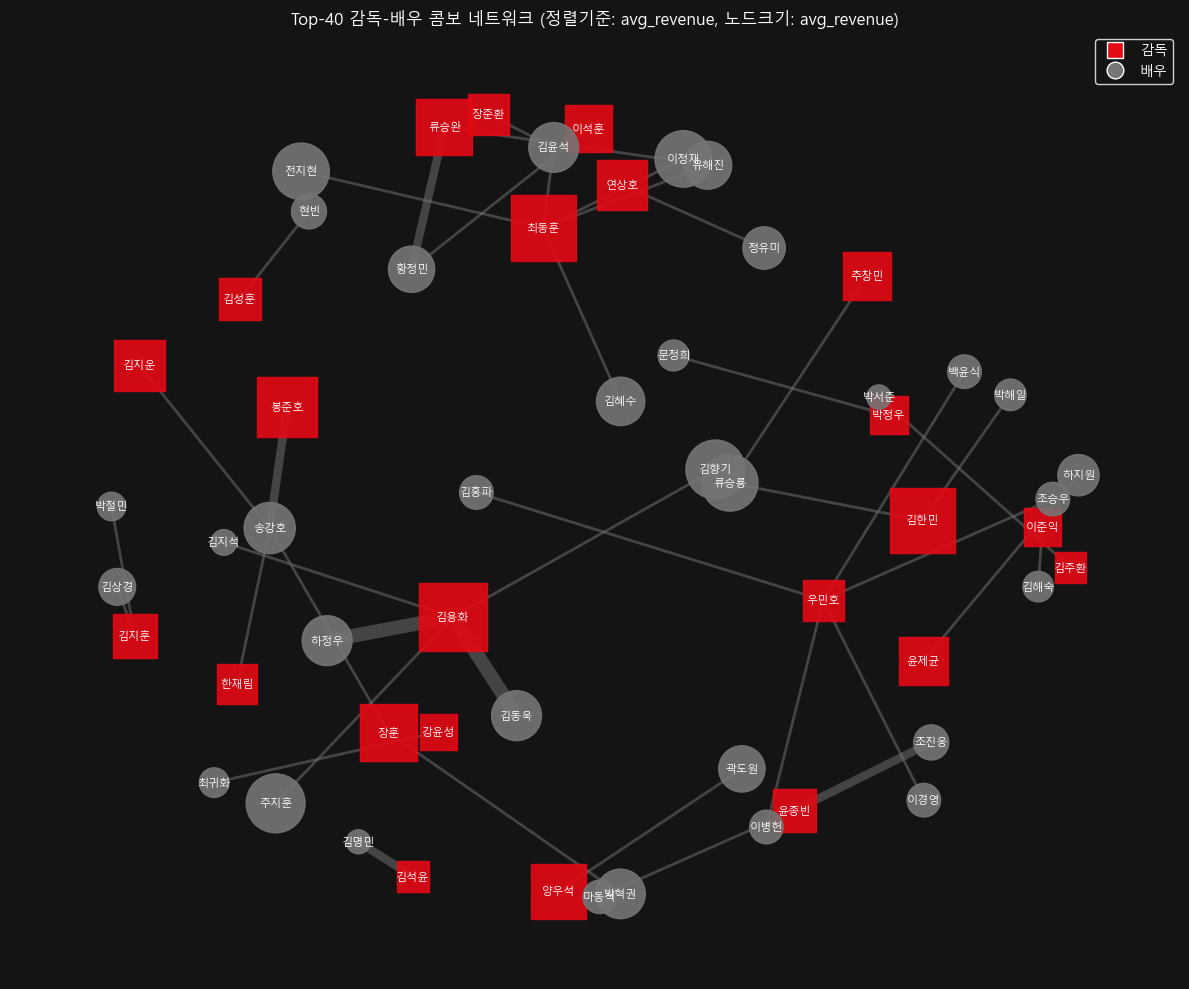

In [8]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from itertools import islice
from IPython.display import display
import warnings

# 경고 메시지 무시 설정
warnings.filterwarnings('ignore', category=UserWarning)

# 파일 경로
file_path = './data/processed/kobis_weekly_final.csv'

# 데이터 로드
df = pd.read_csv(file_path)

print(f"전체 데이터 수: {len(df):,}개")

# 숫자형 컬럼 변환
numeric_columns = ['release_year', 'budget', 'revenue', 'vote_average', 'runtime']
for col in numeric_columns:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')

# 기간 필터링 (2005-2019)
if 'release_year' in df.columns:
    df = df[df['release_year'].between(2005, 2019)]

print(f"필터링 후 데이터 수: {len(df):,}개")

# ROI 및 순이익 계산
df['roi'] = np.where((df['budget'] > 0) & (df['revenue'] > 0),
                     df['revenue'] / df['budget'], np.nan)
df['net_profit'] = df['revenue'] - df['budget']

# 파이프 구분자 파싱 함수
def split_pipe(s):
    return [x.strip() for x in str(s).split('|') if x.strip()]

# 분석 파라미터 설정
TOP_N_CAST = 5  # 상위 배우 N명
MIN_COLLABS = 2  # 최소 협업 횟수
METRIC_EDGE_ORDER = 'avg_revenue'  # 정렬 기준
TOP_K_EDGES = 40  # 상위 K개 엣지

print(f"\n📊 네트워크 분석 설정:")
print(f"상위 배우 수: {TOP_N_CAST}명")
print(f"최소 협업 횟수: {MIN_COLLABS}회")
print(f"정렬 기준: {METRIC_EDGE_ORDER}")
print(f"상위 엣지 수: {TOP_K_EDGES}개")

# 감독-배우 협업 데이터 생성
collaboration_data = []

for _, row in df.iterrows():
    director = str(row.get('director_name_ko', '')).strip()
    if not director:
        continue
    
    cast_list = split_pipe(row.get('cast_names_ko', ''))
    
    for actor in cast_list[:TOP_N_CAST]:
        collaboration_data.append({
            'director_label': director,
            'actor_label': actor,
            'movie_id': row.get('movie_id'),
            'release_year': row.get('release_year'),
            'revenue': row.get('revenue'),
            'budget': row.get('budget'),
            'roi': row.get('roi'),
            'net_profit': row.get('net_profit')
        })

print(f"\n🤝 협업 데이터 생성:")
print(f"총 협업 관계: {len(collaboration_data):,}개")

# 협업 통계 집계
collaboration_df = pd.DataFrame(collaboration_data)
edges_df = (collaboration_df
            .groupby(['director_label', 'actor_label'], as_index=False)
            .agg(
                n_collabs=('movie_id', 'nunique'),
                avg_revenue=('revenue', 'mean'),
                avg_roi=('roi', 'mean'),
                avg_net_profit=('net_profit', 'mean'),
                first_year=('release_year', 'min'),
                last_year=('release_year', 'max')
            )
            .query('n_collabs >= @MIN_COLLABS')
            .sort_values([METRIC_EDGE_ORDER, 'n_collabs'], ascending=[False, False])
           )

print(f"유효한 협업 관계: {len(edges_df)}개")

# 상위 협업 관계 선택
top_edges = edges_df.head(TOP_K_EDGES).copy()

print(f"\n상위 {TOP_K_EDGES}개 협업 관계:")
display_edges = top_edges[['director_label', 'actor_label', 'n_collabs', 'avg_revenue']].copy()
display_edges['avg_revenue'] = display_edges['avg_revenue'].apply(lambda x: f"{x/1e8:.1f}억원")
display_edges.columns = ['감독', '배우', '협업횟수', '평균수익']
display_edges.index = range(1, len(display_edges) + 1)
display(display_edges.head(10))

# 네트워크 그래프 생성
G = nx.Graph()

for _, row in top_edges.iterrows():
    director_node = ('director', row['director_label'])
    actor_node = ('actor', row['actor_label'])
    
    G.add_node(director_node, role='director', label=row['director_label'])
    G.add_node(actor_node, role='actor', label=row['actor_label'])
    
    G.add_edge(director_node, actor_node,
               weight=int(row['n_collabs']),
               avg_revenue=float(row['avg_revenue']) if pd.notna(row['avg_revenue']) else 0.0,
               avg_net_profit=float(row['avg_net_profit']) if pd.notna(row['avg_net_profit']) else 0.0,
               avg_roi=float(row['avg_roi']) if pd.notna(row['avg_roi']) else 0.0)

print(f"\n네트워크 그래프:")
print(f"노드 수: {G.number_of_nodes()}개")
print(f"엣지 수: {G.number_of_edges()}개")

# 한글 폰트 설정
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

# Netflix 스타일 설정
plt.style.use('dark_background')

# Netflix 색상 팔레트
netflix_red = '#e50914'
netflix_dark = '#141414'
netflix_gray = '#757575'
netflix_light_gray = '#b3b3b3'
netflix_dark_gray = '#333333'

# 레이아웃 설정
pos = nx.spring_layout(G, seed=42, k=0.8)

# 노드 분류
directors = [n for n, d in G.nodes(data=True) if d['role'] == 'director']
actors = [n for n, d in G.nodes(data=True) if d['role'] == 'actor']

# 엣지 두께 계산
weights = [G.edges[e]['weight'] for e in G.edges()]
w_min, w_max = min(weights), max(weights)
edge_widths = [2 + 8*((w-w_min)/(w_max-w_min)) for w in weights] if w_max != w_min else [6]*len(weights)

# 노드 크기 계산 (평균 수익 기준)
METRIC_NODE_SIZE = 'avg_revenue'

for _, row in top_edges.iterrows():
    for node_key, label in [(('director', row['director_label']), row['director_label']),
                           (('actor', row['actor_label']), row['actor_label'])]:
        prev_value = G.nodes[node_key].get(METRIC_NODE_SIZE, 0.0)
        current_value = float(row[METRIC_NODE_SIZE]) if pd.notna(row[METRIC_NODE_SIZE]) else 0.0
        if current_value > prev_value:
            G.nodes[node_key][METRIC_NODE_SIZE] = current_value

# 노드 크기 정규화
metric_values = {n: G.nodes[n].get(METRIC_NODE_SIZE, 0.0) for n in G.nodes()}
values_array = np.array(list(metric_values.values()), dtype=float)
values_log = np.log1p(np.abs(values_array))
vmin, vmax = float(values_log.min()), float(values_log.max())

normalized_values = {}
for node in G.nodes():
    if vmax > vmin:
        normalized_values[node] = (np.log1p(abs(metric_values[node])) - vmin) / (vmax - vmin)
    else:
        normalized_values[node] = 0.5

# 노드 크기 설정
MIN_SIZE_ACTOR, MAX_SIZE_ACTOR = 300, 1800
MIN_SIZE_DIRECTOR, MAX_SIZE_DIRECTOR = 500, 2400

node_sizes = {}
for node, norm_val in normalized_values.items():
    if G.nodes[node]['role'] == 'director':
        node_sizes[node] = MIN_SIZE_DIRECTOR + norm_val * (MAX_SIZE_DIRECTOR - MIN_SIZE_DIRECTOR)
    else:
        node_sizes[node] = MIN_SIZE_ACTOR + norm_val * (MAX_SIZE_ACTOR - MIN_SIZE_ACTOR)

# 네트워크 시각화
fig, ax = plt.subplots(figsize=(12, 10), facecolor=netflix_dark)

# 엣지 그리기
nx.draw_networkx_edges(G, pos, width=edge_widths, alpha=0.5, edge_color=netflix_gray)

# 감독 노드 (빨간색 사각형)
nx.draw_networkx_nodes(
    G, pos, nodelist=directors,
    node_size=[node_sizes[n] for n in directors],
    node_color=netflix_red, node_shape='s', alpha=0.9
)

# 배우 노드 (회색 원형)
nx.draw_networkx_nodes(
    G, pos, nodelist=actors,
    node_size=[node_sizes[n] for n in actors],
    node_color=netflix_gray, node_shape='o', alpha=0.9
)

# 라벨
labels = {n: d.get('label', '') for n, d in G.nodes(data=True)}
nx.draw_networkx_labels(G, pos, labels=labels, font_size=8, 
                       font_family='Malgun Gothic', font_color='white')

# 제목 설정
ax.set_title(f'Top-{TOP_K_EDGES} 감독-배우 콤보 네트워크 '
             f'(정렬기준: {METRIC_EDGE_ORDER}, 노드크기: {METRIC_NODE_SIZE})', 
             color='white')

# 배경 설정
ax.set_facecolor(netflix_dark)
plt.axis('off')

# 범례
from matplotlib.lines import Line2D
legend_elements = [
    Line2D([0], [0], marker='s', color='w', label='감독',
           markerfacecolor=netflix_red, markersize=12, linestyle='None'),
    Line2D([0], [0], marker='o', color='w', label='배우',
           markerfacecolor=netflix_gray, markersize=12, linestyle='None')
]
legend = ax.legend(handles=legend_elements, loc='best', frameon=True, 
                  facecolor=netflix_dark, edgecolor='white')
for text in legend.get_texts():
    text.set_color('white')

plt.tight_layout()
fig.patch.set_facecolor(netflix_dark)

print(f"\n🎨 네트워크 시각화 완료!")
plt.show()